<a href="https://colab.research.google.com/github/Sathyakumarnsk/Action_recognition/blob/master/Project_IML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check for GPU connection for this exercise

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dowloading Kaggle Dataset using Kaggle API

The dataset is so huge. So, Please upload the kaggle JSON file and download the data by running the following cells

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list # Testing if kaggle commandline works
!kaggle datasets download -d meetnagadia/human-action-recognition-har-dataset

In [ ]:
! unzip human-action-recognition-har-dataset.zip -d 'human-action-recognition-har-dataset'

In [8]:
import os
main_path = "/content/human-action-recognition-har-dataset/Human Action Recognition"
os.path.exists(main_path)

True

# Dataset: Human Action Recognition Dataset 

The dataset is very balanced one consisting of 15 classes of images of 
day-to-day actions such as:

* 'calling', ’clapping’, ’cycling’, ’dancing’, ‘drinking’, ‘eating’, ‘fighting’, ‘hugging’, ‘laughing’, ‘listening_to_music’, ‘running’, ‘sitting’, ‘sleeping’, texting’, ‘using_laptop’ *

The number of images in the training dataset is about 840 in all classes.

The chosen project objective is to fit a very-light weight classical Image classification model like VGG16 to classify the actions using pre-training

## Load Data into Dataframes

In [9]:
# path to the data files
main_path = "/content/human-action-recognition-har-dataset/Human Action Recognition"

# Load data
test_df     = pd.read_csv("/content/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")
training_df = pd.read_csv("/content/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")

In [10]:

import glob
import random

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

##Exploratory Data Analysis

In [11]:
training_df.head()


,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


# Create a validation Group from the train data

In [12]:
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))

In [13]:
valid_df = valid_df.droplevel(0)  #Drop the first column 

## Remove all validation data from train set

In [14]:
train_df = training_df.drop(valid_df.index)


In [16]:
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print( train_freq,"\n\n",valid_freq)


sitting               756
using_laptop          756
hugging               756
sleeping              756
clapping              756
dancing               756
cycling               756
drinking              756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
running               756
texting               756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting              84
hugging               84
laughing              84
listening_to_music    84
running               84
sitting               84
sleeping              84
texting               84
using_laptop          84
Name: label, dtype: int64


## Pre-process and Data-Augmented using Tensorflow APIs


In [50]:
FINE_TUNING_EPOCHS = 12 
TRAINING_EPOCHS = 10
BATCH_SIZE = 200

image_height = 180 
image_width = 300

In [69]:
# Data agumentation and pre-processing using tensorflow
# First scale the input image value between O and 1.
# Tnesorflow ImageDataGenerator class comes in handy for this

#Create two seperate ImageDatagenerators for training and validation and one for test images

gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = False, #horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)




In [70]:
train_generator = gen.flow_from_dataframe(
    train_df, 
    directory = main_path + "/train", 
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (image_height, image_width), 
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [71]:

test_gen = ImageDataGenerator(rescale = 1./255.)



validation_generator = test_gen.flow_from_dataframe(
    valid_df, 
    directory   = main_path + "/train", 
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width), 
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    directory   = main_path + "/test", 
    x_col       = 'filename',
    color_mode  = "rgb",
    target_size = (image_height, image_width), 
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

Found 1260 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


In [72]:
Label_Mapping_Dict = train_generator.class_indices


# Use Pre-training to fit the custom models for recognition

Let us use famous imagenet models such as VGG and Inception for pre-training

In [73]:
# Custom function for model building

from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    #x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    #x = Dropout(0.2)(x)
    
    outputs = Dense(len(Label_Mapping_Dict), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    #print(model.summary())
    return model  

In [74]:
# Metrics: [Training Loss, Validation Loss, Training Accuracy and Validation Accuracy]
# Callbacks : [Only using Early stopping to avoid overfitting]


def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 2,
                                              min_delta = 0.01,
                                              restore_best_weights = True)
    # early stopping call back
    
    print("Traininable number of layers in base model of {} = {} ".format(base_model.name, fine_tune))
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

In [ ]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()

In [56]:
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Traininable number of layers in base model of vgg16 = 0 
Epoch 1/10
57/57 [==============================] - 212s 3s/step - loss: 2.5794 - accuracy: 0.1757 - val_loss: 2.3305 - val_accuracy: 0.2960
Epoch 2/10
57/57 [==============================] - 199s 3s/step - loss: 2.1431 - accuracy: 0.3260 - val_loss: 1.9518 - val_accuracy: 0.3746
Epoch 3/10
57/57 [==============================] - 169s 3s/step - loss: 1.8890 - accuracy: 0.3909 - val_loss: 1.7937 - val_accuracy: 0.4190
Epoch 4/10
57/57 [==============================] - 180s 3s/step - loss: 1.7830 - accuracy: 0.4228 - val_loss: 1.7238 - val_accuracy: 0.4548
Epoch 5/10
57/57 [==============================] - 167s 3s/step - loss: 1.7195 - accuracy: 0.4395 - val_loss: 1.6706 - val_accuracy: 0.4754
Epoch 6/10
57/57 [==============================] - 160s 3s/step - loss: 1.6674 - accuracy: 0.4594 - val_loss: 1.6488 - val_accuracy: 0.4643
Epoch 7/10
57/57 [==============================] - 175s 3s/step - loss: 1.6325 - accuracy: 0.470

## Tweaking the parameters of the model

After finding that the model was underfitting severely, batch_size and the drop-out layers were commented out and the number of epoch cycles was increased. 

After tweaking the several hyperparameters, the above model was obtained. The inception model described below performed far better in the same training time.

## Plot the learning curves and see the trend

Text(0.5, 1.0, 'Losses of VGG model')

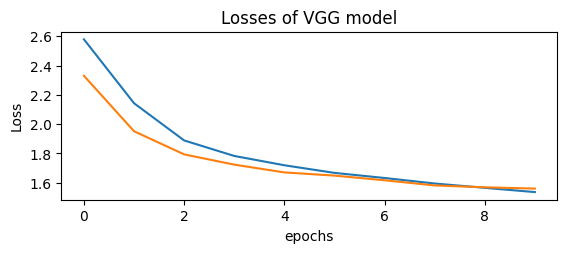

In [57]:
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Losses of VGG model')


Text(0.5, 1.0, 'Accuracy of fitted VGG model')

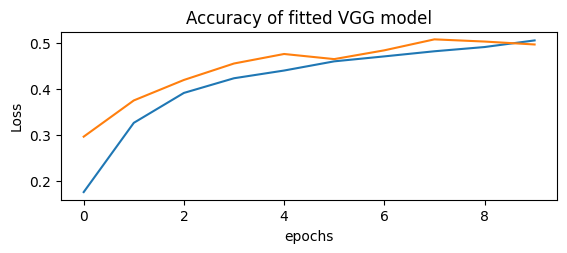

In [58]:
accu, val_accu = history.history['accuracy'], history.history['val_accuracy']

plt.plot(accu, label='Training Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Accuracy of fitted VGG model')

In [62]:
vgg16_model.save_weights("vgg16_model.h5")

# Let us see how 'Inception' performs in the same scenario

In [75]:
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = False,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

In [76]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
#inception_model.summary()


In [101]:
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

Traininable number of layers in base model of inception_resnet_v2 = 0 
Epoch 1/10
57/57 [==============================] - 189s 3s/step - loss: 0.9891 - accuracy: 0.6783 - val_loss: 1.0391 - val_accuracy: 0.6778
Epoch 2/10
57/57 [==============================] - 167s 3s/step - loss: 0.9512 - accuracy: 0.6880 - val_loss: 1.0272 - val_accuracy: 0.6944
Epoch 3/10
57/57 [==============================] - 165s 3s/step - loss: 0.9299 - accuracy: 0.6941 - val_loss: 1.0114 - val_accuracy: 0.6849
Epoch 4/10
57/57 [==============================] - 168s 3s/step - loss: 0.9118 - accuracy: 0.7051 - val_loss: 1.0190 - val_accuracy: 0.6841
Epoch 5/10
57/57 [==============================] - 164s 3s/step - loss: 0.8983 - accuracy: 0.7105 - val_loss: 1.0290 - val_accuracy: 0.6802
Epoch 6/10
57/57 [==============================] - 164s 3s/step - loss: 0.8873 - accuracy: 0.7078 - val_loss: 1.0036 - val_accuracy: 0.6889
Epoch 7/10
57/57 [==============================] - 164s 3s/step - loss: 0.8644 - a

In [ ]:
loss, val_loss = history.history['loss'], history.history['val_loss']
import matplotlib.pyplot as plt
#plt.subplot(2, 1, 1)
#plt.figure(figsize=[5, 3])
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Losses of Inception model')


Text(0.5, 1.0, 'Accuracy of fitted Inception model')

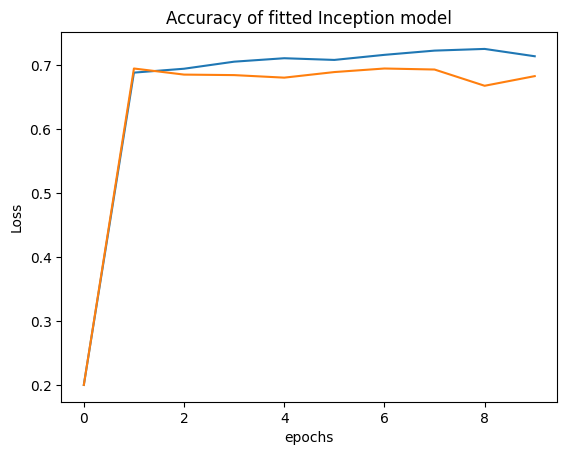

In [138]:
accu, val_accu = history.history['accuracy'], history.history['val_accuracy']

#fig=plt.figure(figsize=(6, 3))

plt.plot(accu, label='Training Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Accuracy of fitted Inception model')
#plt.set_xlim([0, 1])



In [132]:
accuracy_score_vgg = vgg16_model.evaluate(validation_generator)
accuracy_score_inception = inception_model.evaluate(validation_generator)

print("VGG Accuracy: {:.2f}%".format(accuracy_score_vgg[1] * 100))
print("VGG Loss: {:.3f}".format(accuracy_score_vgg[0]))


print("Inception Accuracy: {:.2f}%".format(accuracy_score_inception[1] * 100))
print("Inception Loss: {:.3f}".format(accuracy_score_inception[0]))

7/7 [==============================] - 7s 911ms/step - loss: 1.0126 - accuracy: 0.6825
VGG Accuracy: 51.51%
VGG Loss: 1.547
Inception Accuracy: 68.25%
Inception Loss: 1.013


In [145]:
inception_model.save_weights("inception_model.h5")

In [142]:
# Helper function to plot some images

import matplotlib.pyplot as plt

class_names=list(Label_Mapping_Dict.keys())

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])

27/27 [==============================] - 24s 889ms/step


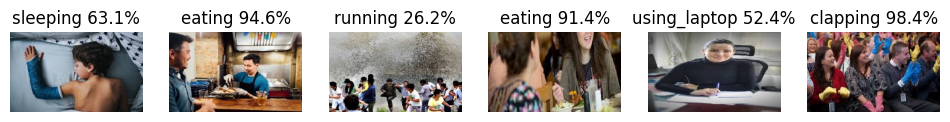

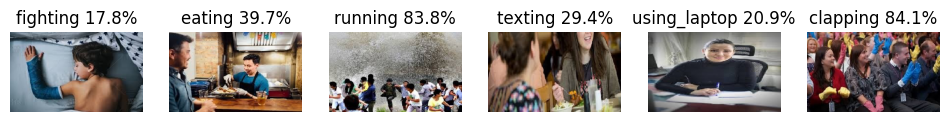

In [143]:
# Predict and display the result of sample images in test_data
# Note that Inception model has higher accuracy than VGG16
# We will have to infer the results of the test_data ourselves


# Inception modle
test_generator.reset()
x = next(test_generator)
inception_test_preds = inception_model.predict(test_generator)
#inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

plot_images(x, None, inception_test_preds)

#VGG model
test_generator.reset()
x = next(test_generator)
vgg16_test_preds = vgg16_model.predict(test_generator)
#vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)
plot_images(x, None, vgg16_test_preds)


## Let us try to plot the Confusion matrix between the two models

In [98]:
# Helper function to plot confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

In [97]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()

vgg16_val_preds = vgg16_model.predict(validation_generator)
vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)

validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis = 1)



7/7 [==============================] - 10s 911ms/step


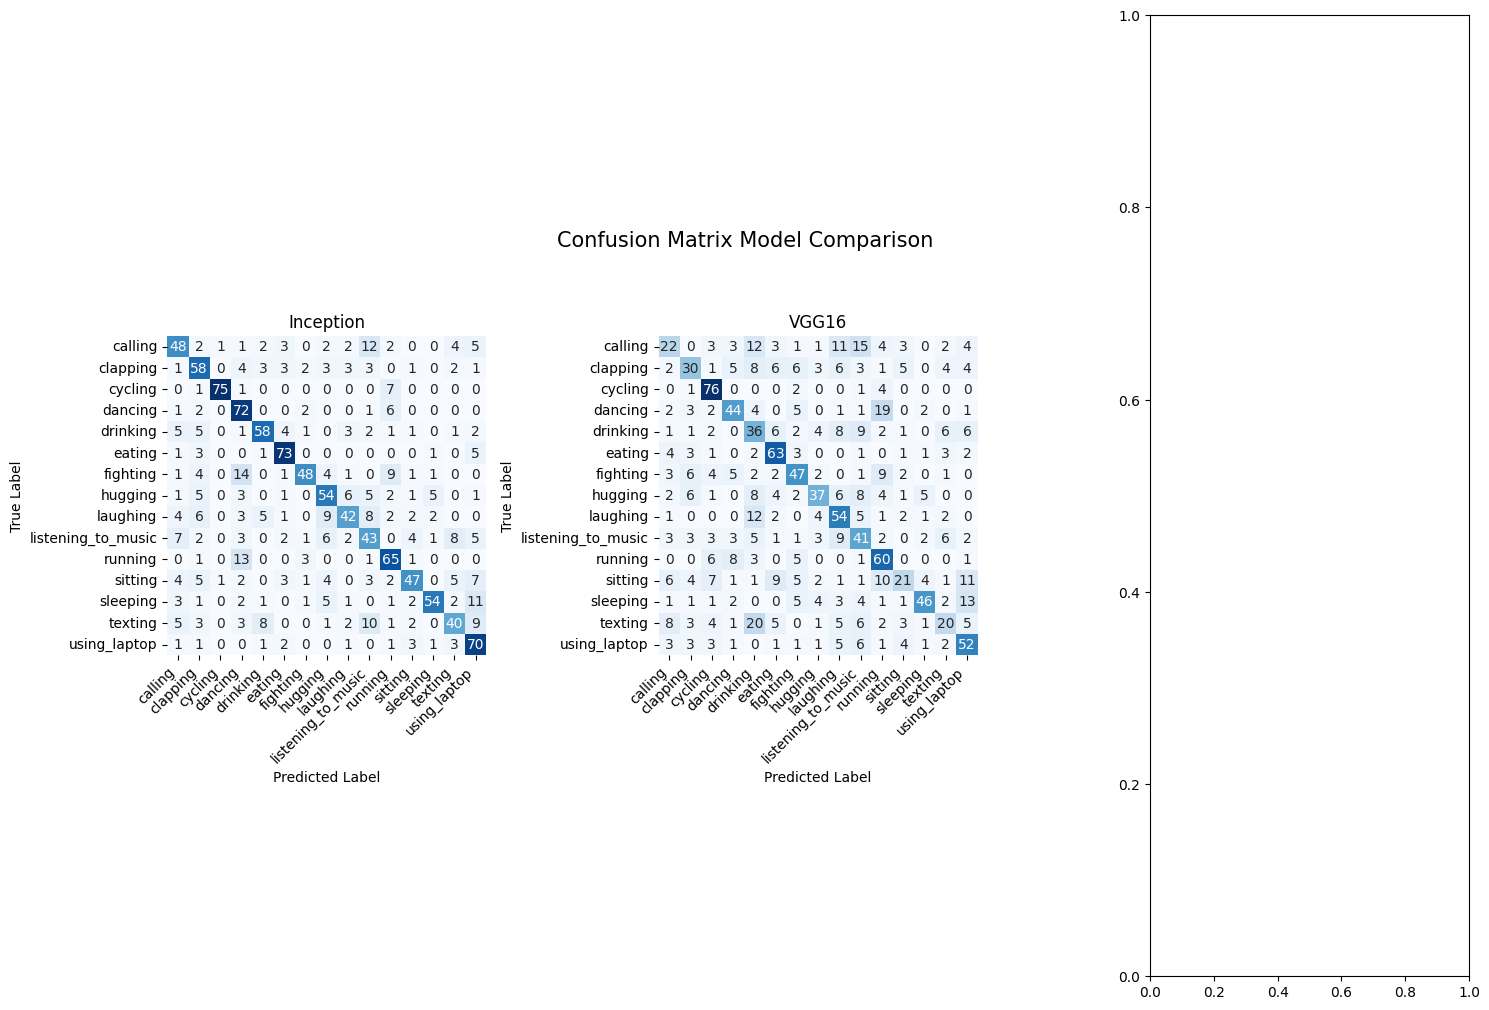

In [99]:
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = validation_generator.classes

plot_heatmap(true_classes, inception_val_pred_classes, class_names, ax1, title = "Inception")    
plot_heatmap(true_classes, vgg16_val_pred_classes, class_names, ax2, title = "VGG16")    
 
fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# Results & Conclusion

Inception model converges much quickly and fastly to the dataset therbey offering higher accuracy in shorter time. But, However, it should be noted that the Inception ResNet V2 is only just about half the size of a VG-model! (215MB Vs. 528 MB).

In summary, this notebook demonstrates the method of using different classical image classification architectures for classifying actions. But the models still need improvement